In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

ACTION  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0       1     39353   85475         117961         118300         123472   
1       1     17183    1540         117961         118343         123125   
2       1     36724   14457         118219         118220         117884   
3       1     36135    5396         117961         118343         119993   
4       1     42680    5905         117929         117930         119569   

   ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0      117905            117906       290919     117908  
1      118536            118536       308574     118539  
2      117879            267952        19721     117880  
3      118321            240983       290919     118322  
4      119323            123932        19793     119325

In [172]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in range(df_train.columns.size):
    df_train.iloc[:,i] = le.fit_transform(df_train.iloc[:,i])
    df_test.iloc[:,i] = le.fit_transform(df_test.iloc[:,i])

In [173]:
shuffled = df_train[df_train['ACTION']==1].sample(frac=1)
train = np.array_split(shuffled,5)

In [174]:
for i in range(len(train)):
    train[i] = train[i].append(df_train[df_train['ACTION']==0])

In [175]:
x = []
y = []
for i in range(len(train)):
    x.append(train[i].drop('ACTION',axis=1))
    y.append(train[i]['ACTION'])

In [176]:
test_input = df_test.drop('id',axis=1)

In [177]:
from sklearn.model_selection import train_test_split                                                  # x_train = y_train = x_valid = y_valid = [0]*5
x_train1, x_valid1, y_train1, y_valid1 = train_test_split(x[0],y[0],test_size=0.2,random_state=1)     #x_train and related are lists (of size 5) of dataframes
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(x[1],y[1],test_size=0.2,random_state=1)
x_train3, x_valid3, y_train3, y_valid3 = train_test_split(x[2],y[2],test_size=0.2,random_state=1)
x_train4, x_valid4, y_train4, y_valid4 = train_test_split(x[3],y[3],test_size=0.2,random_state=1)
x_train5, x_valid5, y_train5, y_valid5 = train_test_split(x[4],y[4],test_size=0.2,random_state=1)

In [178]:
#CATBOOST MODEL on x_train[0], y_train[0]
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

cat_features = list(range(x_train1.columns.size))                         #classified features on which our model will train

cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric="AUC",
    random_seed=1,
    cat_features = cat_features
)

cat_model.fit(x_train1,y_train1,eval_set=(x_valid1,y_valid1),use_best_model=True)

Learning rate set to 0.050233
0:	test: 0.6656705	best: 0.6656705 (0)	total: 64.4ms	remaining: 1m 4s
1:	test: 0.6907002	best: 0.6907002 (1)	total: 122ms	remaining: 1m 1s
2:	test: 0.7239937	best: 0.7239937 (2)	total: 168ms	remaining: 55.8s
3:	test: 0.7448931	best: 0.7448931 (3)	total: 216ms	remaining: 53.8s
4:	test: 0.7568664	best: 0.7568664 (4)	total: 251ms	remaining: 50s
5:	test: 0.7722087	best: 0.7722087 (5)	total: 290ms	remaining: 48.1s
6:	test: 0.7779344	best: 0.7779344 (6)	total: 333ms	remaining: 47.3s
7:	test: 0.7800452	best: 0.7800452 (7)	total: 387ms	remaining: 48s
8:	test: 0.7826834	best: 0.7826834 (8)	total: 425ms	remaining: 46.8s
9:	test: 0.8144512	best: 0.8144512 (9)	total: 451ms	remaining: 44.7s
10:	test: 0.8134116	best: 0.8144512 (9)	total: 481ms	remaining: 43.3s
11:	test: 0.8303232	best: 0.8303232 (11)	total: 506ms	remaining: 41.6s
12:	test: 0.8323927	best: 0.8323927 (12)	total: 521ms	remaining: 39.6s
13:	test: 0.8385500	best: 0.8385500 (13)	total: 577ms	remaining: 40.6s


In [179]:
cat_boost_score = roc_auc_score(y_valid1,cat_model.predict(x_valid1))
print(cat_boost_score)                                                          #Accuracy for cat_boost model

0.793496369955674


In [180]:
#ADABOOST CLASSIFIER
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(learning_rate=1,n_estimators=10000,random_state=1)
clf.fit(x_train2,y_train2)

AdaBoostClassifier(learning_rate=1, n_estimators=10000, random_state=1)

In [181]:
clf_score = roc_auc_score(y_valid2,clf.predict(x_valid2))
print(clf_score)                                                                #Accuracy for adaboost model

0.6778776094342003


In [182]:
#XGBOOST 
import xgboost as xgb
model_xgb = xgb.XGBClassifier(learning_rate=1,n_estimators=100,eval_metric='auc')
eval_set = [(x_valid3,y_valid3)]
model_xgb.fit(x_train3,y_train3,eval_set=eval_set)

[0]	validation_0-auc:0.66063
[1]	validation_0-auc:0.68363
[2]	validation_0-auc:0.68766
[3]	validation_0-auc:0.69888
[4]	validation_0-auc:0.71131
[5]	validation_0-auc:0.74664
[6]	validation_0-auc:0.75398
[7]	validation_0-auc:0.77570
[8]	validation_0-auc:0.77574
[9]	validation_0-auc:0.77294
[10]	validation_0-auc:0.77697
[11]	validation_0-auc:0.77363
[12]	validation_0-auc:0.77541
[13]	validation_0-auc:0.77279
[14]	validation_0-auc:0.77653
[15]	validation_0-auc:0.77868
[16]	validation_0-auc:0.78051
[17]	validation_0-auc:0.78196
[18]	validation_0-auc:0.78342
[19]	validation_0-auc:0.78284
[20]	validation_0-auc:0.78289
[21]	validation_0-auc:0.78285
[22]	validation_0-auc:0.78212
[23]	validation_0-auc:0.78399
[24]	validation_0-auc:0.78226
[25]	validation_0-auc:0.78209
[26]	validation_0-auc:0.78488
[27]	validation_0-auc:0.78348
[28]	validation_0-auc:0.78274
[29]	validation_0-auc:0.78510
[30]	validation_0-auc:0.78931
[31]	validation_0-auc:0.79028
[32]	validation_0-auc:0.79147
[33]	validation_0-au

C:\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[41]	validation_0-auc:0.80177
[42]	validation_0-auc:0.80259
[43]	validation_0-auc:0.80221
[44]	validation_0-auc:0.80304
[45]	validation_0-auc:0.80497
[46]	validation_0-auc:0.80603
[47]	validation_0-auc:0.80735
[48]	validation_0-auc:0.80637
[49]	validation_0-auc:0.80687
[50]	validation_0-auc:0.80607
[51]	validation_0-auc:0.80592
[52]	validation_0-auc:0.80658
[53]	validation_0-auc:0.80746
[54]	validation_0-auc:0.80697
[55]	validation_0-auc:0.80844
[56]	validation_0-auc:0.80867
[57]	validation_0-auc:0.80769
[58]	validation_0-auc:0.80741
[59]	validation_0-auc:0.80811
[60]	validation_0-auc:0.80747
[61]	validation_0-auc:0.80787
[62]	validation_0-auc:0.80681
[63]	validation_0-auc:0.80659
[64]	validation_0-auc:0.80732
[65]	validation_0-auc:0.80770
[66]	validation_0-auc:0.80823
[67]	validation_0-auc:0.80880
[68]	validation_0-auc:0.80815
[69]	validation_0-auc:0.80690
[70]	validation_0-auc:0.80768
[71]	validation_0-auc:0.80801
[72]	validation_0-auc:0.80798
[73]	validation_0-auc:0.80808
[74]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [183]:
xgb_score = roc_auc_score(y_valid3,model_xgb.predict(x_valid3))
print(xgb_score)                                                        #Accuracy for xgboost model

0.7421393076505889


In [184]:
#RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(x_train4,y_train4)

RandomForestClassifier(n_estimators=1000)

In [185]:
rfc_score = roc_auc_score(y_valid4,rfc.predict(x_valid4))
print(rfc_score)                                                        #Accuracy for random forest

0.7575487338674474


In [186]:
#KNN 
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(weights='distance')
neigh.fit(x_train5,y_train5)

KNeighborsClassifier(weights='distance')

In [187]:
neigh_score = roc_auc_score(y_valid5,neigh.predict(x_valid5))
print(neigh_score)                                                      #Accuracy for knn model

0.6162646113416199


In [188]:
result_cat = cat_model.predict(test_input)
result_clf = clf.predict(test_input)
result_xgb = model_xgb.predict(test_input)
result_rfc = rfc.predict(test_input)
result_neigh = neigh.predict(test_input)

In [221]:
result = np.average([result_cat,result_clf,result_xgb,result_rfc,result_neigh],axis=0,weights=[cat_boost_score,clf_score,xgb_score,rfc_score,neigh_score])
result


array([1.        , 1.        , 1.        , ..., 0.81103544, 1.        ,
       1.        ])

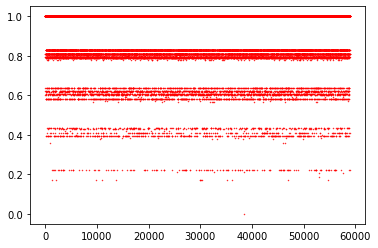

In [222]:
plt.scatter(range(len(result)),result,s=0.2,color='r')

In [233]:
average_score = np.average(result)
for i in range(len(result)):
    if result[i]>=average_score-np.var(result):
        result[i]=1
    else :
        result[i]=0

In [235]:
predictions = pd.DataFrame({'Id':df_test['id']+1,'Action':result})
predictions.to_csv('Submission21.csv',index=False)